# 1. 数据导入

TSDataset 是 PaddleTS 中最主要的类之一，其被设计用来表示绝大多数时序样本数据。通常，时序数据可以分为以下几种：

单变量数据，只包含单列的预测目标，同时可以包含单列或者多列协变量

多变量数据，包含多列预测目标，同时可以包含单列或者多列协变量

TSDataset 需要包含time_index属性，time_index支持 pandas.DatetimeIndex 和 pandas.RangeIndex 两种类型。

In [1]:
from paddlets import TSDataset

PaddleTS内集成了部分公开数据集，便于用户使用；基于内置数据集，我们可以轻松的完成TSDataset的构建。

In [2]:
from paddlets.datasets.repository import get_dataset, dataset_list
print(f"built-in datasets: {dataset_list()}")

built-in datasets: ['UNI_WTH', 'ETTh1', 'ETTm1', 'ECL', 'WTH', 'NAB_TEMP', 'psm_train', 'psm_test']


In [6]:
dataset = get_dataset('UNI_WTH')
print(type(dataset))

<class 'paddlets.datasets.tsdataset.TSDataset'>


<AxesSubplot:xlabel='date'>

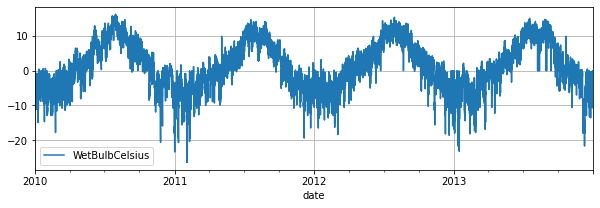

In [11]:
dataset.plot()

在实际应用的场景中，用户可以基于pandas.DataFrame或者CSV文件去构建TSDataset

<AxesSubplot:xlabel='time_col'>

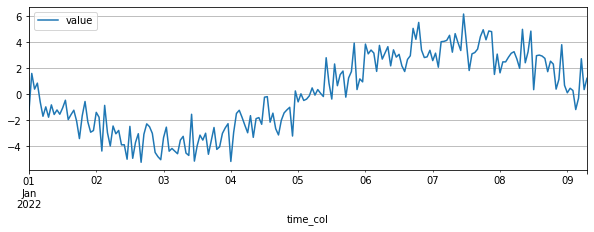

In [12]:
import pandas as pd
import numpy as np
from paddlets import TSDataset

x = np.linspace(-np.pi, np.pi, 200)
sinx = np.sin(x) * 4 + np.random.randn(200)

df = pd.DataFrame(
    {
        'time_col': pd.date_range('2022-01-01', periods=200, freq='1h'),
        'value': sinx
    }
)
custom_dataset = TSDataset.load_from_dataframe(
    df,  #Also can be path to the CSV file
    time_col='time_col',
    target_cols='value',
    freq='1h'
)
custom_dataset.plot()

load_from_dataframe函数中
1. df: 代表原始pandas.DataFrame数据；
2. time_col: 代表时间列，如果不指定，将使用df的index作为默认时间列，支持 pandas.DatetimeIndex 和 pandas.RangeIndex 两种类型，其中str类型的时间列会默认转换成pandas.DatetimeIndex类型；int类型的时间列会默认转换成pandas.RangeInde类型；
3. target_cols: 用于表示希望预测列，支持多列的指定，如不指定，除time_col外的所有列都将作为默认的target_cols列；
4. freq: 代表时间样本的频率，如'1h'代表一个小时、'1min'代表一分钟、如果不指定，将会自动推测（如果数据有缺失，将会推测失败，因此建议保留该参数的传递）

当然load_from_dataframe还支持很多其他的特性，如缺失值填充、尾部Nan值自动去除等，具体使用方法可以参考TSDataset的API文档

# 2. 数据查看以及分析

通过调用 TSDataset.summary 方法即可实现对数据统计信息的查看。

In [9]:
dataset.summary()

,WetBulbCelsius
missing,0.000000
count,35064.000000
mean,1.026081
std,6.898354
min,-26.400000
25%,-3.800000
50%,0.600000
75%,6.600000
max,16.300000


基于上述的信息，用户可以对数据的基本信息有大致的了解，其中很多信息可以帮助我们更好的理解数据，例如上述中 missing 变量用于表示数据的缺失值比例，我们多数深度模型要求数据不能有缺失值，因此如果不为零，数据在入模前需要进行缺失值填充以及处理。
我们也可以使用一些PaddleTS中的高级的分析组件对数据进行进一步的分析。例如我们可以使用 FFT 算子进行数据频域属性分析。

[2022-11-02 14:47:58,021] [paddlets.analysis.frequency_domain] [WARNING] It's suggested to assign a positive number to the fs parameter.


<module 'matplotlib.pyplot' from '/home/work/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/pyplot.py'>

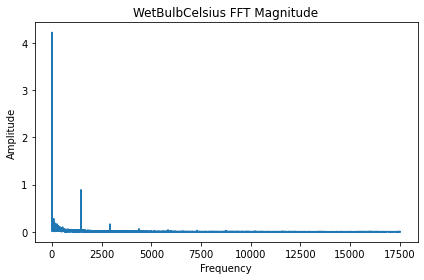

In [10]:
#FFT
from paddlets.analysis import FFT
fft = FFT()
res = fft(dataset, columns='WetBulbCelsius')
fft.plot()

# 3. 模型训练及预测

完成TSDataset的构建后，可以进行后续的模型训练以及预测工作; PaddleTS目前支持时序预测、时序异常检测以及时序表征等三种模型训练以及应用

这里基于时序预测模型以及任务进行示例说明，下面提供了一个如何基于时序数据去构建深度神经网络模型的例子，包括模型的训练以及预测。

## 3.1. 构建训练、验证以及测试数据集

<AxesSubplot:xlabel='date'>

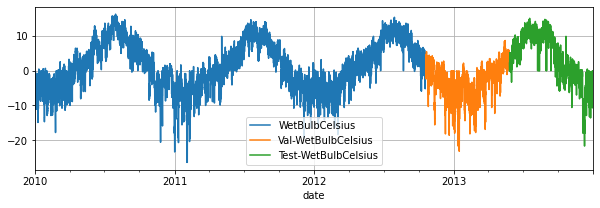

In [13]:
train_dataset, val_test_dataset = dataset.split(0.7)
val_dataset, test_dataset = val_test_dataset.split(0.5)
train_dataset.plot(add_data=[val_dataset,test_dataset], labels=['Val', 'Test'])

## 3.2. 模型训练

我们将基于内置的MLPRegressor模型作为示例，用于展示如何进行模型的训练及预测。
初始化MLPRegressor模型，其中包含两个必传的参数：
1. in_chunk_len: 输入时序窗口的大小，代表每次训练以及预测时候输入到模型中的前序的时间步长。
2. out_chunk_len: 输出时序窗口的大小，代表每次训练以及预测时候输出的后续的时间步长。

同时也有很多其他的可选参数用于控制 MLPRegressor 模型的初始化，如 max_epochs , optimizer_params 等。

In [14]:
from paddlets.models.forecasting import MLPRegressor
mlp = MLPRegressor(
    in_chunk_len = 7 * 24,
    out_chunk_len = 24,
    max_epochs=100
)

现在，我们可以使用 train_dataset 和 val_dataset 对初始化好的模型进行训练，其中 val_dataset 是可选的。

In [15]:
mlp.fit(train_dataset, val_dataset)

[2022-11-02 14:57:40,804] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 6.498729| val_0_mae: 2.108200| 0:00:02s
[2022-11-02 14:57:43,024] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 4.636641| val_0_mae: 2.231978| 0:00:04s
[2022-11-02 14:57:45,173] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 4.367625| val_0_mae: 1.925581| 0:00:06s
[2022-11-02 14:57:47,370] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 4.139342| val_0_mae: 1.915246| 0:00:08s
[2022-11-02 14:57:49,596] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 4.037877| val_0_mae: 1.943281| 0:00:11s
[2022-11-02 14:57:51,738] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 3.967969| val_0_mae: 1.928276| 0:00:13s
[2022-11-02 14:57:53,994] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 3.864211| val_0_mae: 1.946018| 0:00:15s
[2022-11-02 14:57:56,179] [paddlets.models.common.callb

## 3.3. 模型预测

接下来，我们用已经训练好的模型进行预测，输出的预测结果类型是TSDataset, 同时其长度等于 out_chunk_len 。

<AxesSubplot:>

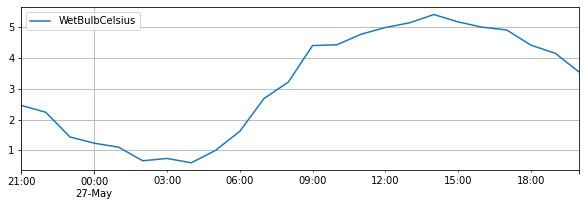

In [16]:
subset_test_pred_dataset = mlp.predict(val_dataset)
subset_test_pred_dataset.plot()

我们截取测试集中对应的真实数据，和我们的预测结果进行对比，结果如下：

<AxesSubplot:xlabel='date'>

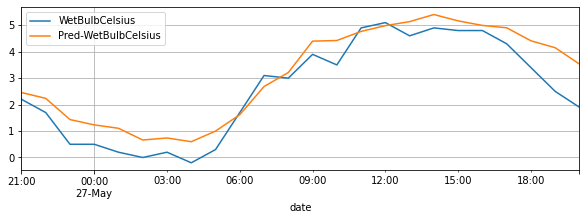

In [18]:
subset_test_dataset, _ = test_dataset.split(len(subset_test_pred_dataset.target))
subset_test_dataset.plot(add_data=subset_test_pred_dataset, labels=['Pred'])

如果我们想要预测的长度大于模型初始化时候指定的 out_chunk_len 长度，我们可以通过调用 recursive_predict 接口来实现。其支持指定想要输出的预测长度；如上述的 UNI_WTH 数据集，我们想要预测未来96个小时的 WetBulbCelsuis , 我们可以通过调用 recursive_predict 通过如下方法实现：

<AxesSubplot:xlabel='date'>

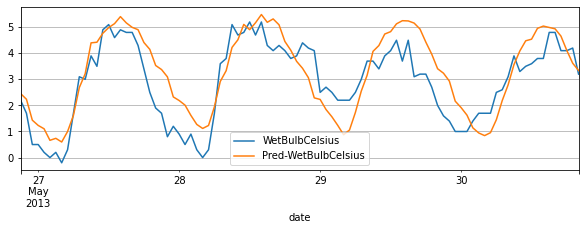

In [19]:
subset_test_pred_dataset = mlp.recursive_predict(val_dataset, 24 * 4)
subset_test_dataset, _ = test_dataset.split(len(subset_test_pred_dataset.target))
subset_test_dataset.plot(add_data=subset_test_pred_dataset, labels=['Pred'])

# 4. 评估和回测

现在，我们有了预测数据和真实数据，可以计算相应的metrics指标

In [20]:
from paddlets.metrics import MAE
mae = MAE()
mae(subset_test_dataset, subset_test_pred_dataset)

{'WetBulbCelsius': 0.7928851215789715}

上面，我们只计算了测试集中部分数据的metrics指标，我们可以通过 backtest 实现对整个测试集的metrics指标计算。

In [21]:
from paddlets.utils import backtest
metrics_score = backtest(
    data=val_test_dataset,
    model=mlp,
    start=0.5,
    predict_window=24,
    stride=24,
    metric=mae
)
print(f"mae: {metrics_score}")

Backtest Progress: 100%|██████████| 220/220 [00:04<00:00, 53.47it/s]

mae: {'WetBulbCelsius': 1.5177571760284516}


# 5. 协变量

PaddleTS 同样支持协变量数据的构建以及入模训练，用于提供除target外的额外信息，帮助我们提高时序模型效果。
时序数据中的协变量可以分为以下三种：
1. known_covariate(已知协变量) ，指可在预测未来时间已知的变量，例如天气预报
2. observed_covariate(观测协变量) ，指只能在历史中观察到的变量数据，例如测量的温度
3. static_covariate(静态协变量) ，指整个时间范围内保持不变的变量，在多数序组合预测中会使用

## 5.1 自动构建日期相关协变量

我们可以使用 paddlets.transform 中的 TimeFeatureGenerator 去自动生成日期与时间相关的协变量。如是否节假日，当前是每年的第几周等信息，因为这些信息在预测未来数据的时候也是已知的，因此其属于 known_covariate(已知协变量)。 在以下示例中，我们会生成三个时间相关的协变量，分别代表 一年中的第几天 、一周中的第几天、 是否是工作日 。

In [22]:
from paddlets.transform import TimeFeatureGenerator
time_feature_generator = TimeFeatureGenerator(feature_cols=['dayofyear', 'weekofyear', 'is_workday'])
dataset_gen_target_cov = time_feature_generator.fit_transform(dataset)
print(dataset_gen_target_cov)
print(dataset_gen_target_cov.known_cov)

                     WetBulbCelsius  dayofyear  weekofyear  is_workday
date                                                                  
2010-01-01 00:00:00           -10.3          1          53         0.0
2010-01-01 01:00:00           -10.3          1          53         0.0
2010-01-01 02:00:00           -10.3          1          53         0.0
2010-01-01 03:00:00           -10.3          1          53         0.0
2010-01-01 04:00:00           -10.0          1          53         0.0
...                             ...        ...         ...         ...
2013-12-31 19:00:00             0.0        365           1         1.0
2013-12-31 20:00:00             0.0        365           1         1.0
2013-12-31 21:00:00             0.0        365           1         1.0
2013-12-31 22:00:00             0.0        365           1         1.0
2013-12-31 23:00:00            -1.5        365           1         1.0

[35064 rows x 4 columns]
                     dayofyear  weekofyear  is_work

## 5.2. 自定义协变量

很多实际场景中，我们原始数据中即包含了需要使用的协变量，我们可以基于pandas.DataFrame或者CSV文件去构建一个只包含协变量的TSDataset 

In [23]:
import pandas as pd
from paddlets import TSDataset
df = pd.DataFrame(
    {
        'time_col': pd.date_range(
            dataset.target.time_index[0],
            periods=len(dataset.target),
            freq=dataset.freq
        ),
        'cov1': [i for i in range(len(dataset.target))]
    }
)
dataset_cus_cov = TSDataset.load_from_dataframe(
    df,
    time_col='time_col',
    known_cov_cols='cov1',
    freq=dataset.freq
)
print(dataset_cus_cov)

                      cov1
time_col                  
2010-01-01 00:00:00      0
2010-01-01 01:00:00      1
2010-01-01 02:00:00      2
2010-01-01 03:00:00      3
2010-01-01 04:00:00      4
...                    ...
2013-12-31 19:00:00  35059
2013-12-31 20:00:00  35060
2013-12-31 21:00:00  35061
2013-12-31 22:00:00  35062
2013-12-31 23:00:00  35063

[35064 rows x 1 columns]


接下来，我们可以将新构建只包含协变量的TSDataset和原有只包含target信息的TSDataset进行聚合。

In [24]:
dataset_cus_target_cov = TSDataset.concat([dataset, dataset_cus_cov])
print(dataset_cus_target_cov)

                     WetBulbCelsius   cov1
date                                      
2010-01-01 00:00:00           -10.3      0
2010-01-01 01:00:00           -10.3      1
2010-01-01 02:00:00           -10.3      2
2010-01-01 03:00:00           -10.3      3
2010-01-01 04:00:00           -10.0      4
...                             ...    ...
2013-12-31 19:00:00             0.0  35059
2013-12-31 20:00:00             0.0  35060
2013-12-31 21:00:00             0.0  35061
2013-12-31 22:00:00             0.0  35062
2013-12-31 23:00:00            -1.5  35063

[35064 rows x 2 columns]


当然，很多中情况下，target信息以及协变量信息是存储在一起的，因此我们也可以通过load_from_dataframe函数将target以及协变量信息基于同一个csv文件或者DataFrame一起导入并构建成一个TSDataset

# 6. 基于包含协变量数据的模型训练

基于前面构建好的包含协变量的数据，接下来，我们去训练一个时序预测场景下的RNNBlockRegressor模型作为一个例子。

In [25]:
from paddlets.models.forecasting import RNNBlockRegressor
rnn_reg = RNNBlockRegressor(
    in_chunk_len = 7 * 24,
    out_chunk_len = 24,
    skip_chunk_len = 0,
    sampling_stride = 24,
    max_epochs = 100
)

构建训练、验证以及测试数据集

In [26]:
train_dataset, val_test_dataset = dataset_gen_target_cov.split(0.8)
val_dataset, test_dataset = val_test_dataset.split(0.5)

通过 paddlets.transform 的 StandardScaler 对数据进行归一化。

In [27]:
from paddlets.transform import StandardScaler
scaler = StandardScaler()
scaler.fit(train_dataset)
train_dataset_scaled = scaler.transform(train_dataset)
val_test_dataset_scaled = scaler.transform(val_test_dataset)
val_dataset_scaled = scaler.transform(val_dataset)
test_dataset_scaled = scaler.transform(test_dataset)

现在我们可以训练模型并对模型效果进行评估。

In [28]:
rnn_reg.fit(train_dataset_scaled, val_dataset_scaled)

[2022-11-02 15:08:30,946] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 0.970474| val_0_mae: 0.773957| 0:00:09s
[2022-11-02 15:08:40,010] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.913050| val_0_mae: 0.744028| 0:00:18s
[2022-11-02 15:08:49,042] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.855154| val_0_mae: 0.711538| 0:00:27s
[2022-11-02 15:08:57,917] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.790377| val_0_mae: 0.667910| 0:00:36s
[2022-11-02 15:09:02,302] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.708783| val_0_mae: 0.602184| 0:00:40s
[2022-11-02 15:09:03,577] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.600264| val_0_mae: 0.511285| 0:00:41s
[2022-11-02 15:09:04,625] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.469953| val_0_mae: 0.426064| 0:00:42s
[2022-11-02 15:09:05,671] [paddlets.models.common.callb

In [29]:
from paddlets.utils import backtest
metrics_score = backtest(
    data=val_test_dataset_scaled,
    model=rnn_reg,
    start=0.5,
    predict_window=24,
    stride=24,
    metric=mae
)
print(f"mae: {metrics_score}")

Backtest Progress:  99%|█████████▉| 146/147 [00:04<00:00, 35.18it/s]

mae: {'WetBulbCelsius': 0.301671578348008}


# 7. Pipeline

PaddleTS支持pipeline的构建以及串联，我们可以通过Pipeline的方法，将上述提到的数据处理流程整合到一起，提供一个端到端的数据建模解决方案：

In [30]:
from paddlets.pipeline import Pipeline

In [31]:
train_dataset, val_test_dataset = dataset.split(0.8)
val_dataset, test_dataset = val_test_dataset.split(0.5)

我们通过添加时间相关的特征生成模块、数据归一化模块以及模型训练模块去初始化一个Pipeline对象。

In [32]:
pipe = Pipeline([
    (TimeFeatureGenerator, {"feature_cols": ['dayofyear', 'weekofyear', 'is_workday'], "extend_points": 24}),
    (StandardScaler, {}),
    (RNNBlockRegressor, {
        "in_chunk_len": 7 * 24,
        "out_chunk_len": 24,
        "skip_chunk_len": 0,
        "sampling_stride": 24,
        "max_epochs": 100
    })
])

接下来，我们可以对Pipeline整体进行训练以及效果评估，Pipeline会自动按序调用内部的模块进行数据的处理以及模型训练。

In [33]:
pipe.fit(train_dataset, val_dataset)

[2022-11-02 15:10:40,075] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 0.970560| val_0_mae: 0.751753| 0:00:08s
[2022-11-02 15:10:49,098] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.912606| val_0_mae: 0.721962| 0:00:18s
[2022-11-02 15:10:58,138] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.854178| val_0_mae: 0.687151| 0:00:27s
[2022-11-02 15:11:07,041] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.787685| val_0_mae: 0.644228| 0:00:35s
[2022-11-02 15:11:11,588] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.705626| val_0_mae: 0.585041| 0:00:40s
[2022-11-02 15:11:12,938] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.602265| val_0_mae: 0.504624| 0:00:41s
[2022-11-02 15:11:13,974] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.468437| val_0_mae: 0.419753| 0:00:42s
[2022-11-02 15:11:15,034] [paddlets.models.common.callb

In [34]:
from paddlets.utils import backtest
metrics_score = backtest(
    data=val_test_dataset,
    model=pipe,
    start=0.5,
    predict_window=24,
    stride=24,
    metric=mae
)
print(f"mae: {metrics_score}")

Backtest Progress: 100%|██████████| 147/147 [00:43<00:00,  3.41it/s]

mae: {'WetBulbCelsius': 2.875698359433589}


# 8. AutoTS

AutoTS是用于支持PaddleTS的自动机器学习能力组件。

AutoTS 可以支持 PaddleTS 模型和 pipeline 的自动超参数选择，减少人工介入成本，降低专业门槛。

In [35]:
from paddlets.automl.autots import AutoTS

下面，我们利用 MLPRegressor 初始化了一个 AutoTS 模型，其中它的 in_chunk_len 是96，out_chunk_len 是2。

In [36]:
autots_model = AutoTS(MLPRegressor, 96, 2)

接下来我们可以像应用一个普通的 PaddleTS 模型一样训练这个模型，并将其用于预测。

AutoTS 为 PaddleTS 模型内置了一套推荐的默认检索空间，所以这个 MLPRegressor 在默认的检索空间下面进行超参优化，并利用所发现的最优参数拟合这个 MLPRegressor。

(温馨提示，AutoTS训练涉及到自动寻参以及多轮训练，fit过程会比较慢，请耐心等待)

In [ ]:
autots_model.fit(train_dataset)
predicted_tsdataset = autots_model.predict(train_dataset)

AutoTS 也允许我们获取超参优化过程中所找到的最优的参数

In [42]:
best_param = autots_model.best_param